# Simulation based hypothesis testing


### Notebook setup

In [1]:
# Install stats library
%pip install --quiet ministats 


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Figures setup
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    style="whitegrid",
    rc={'figure.figsize': (7, 2)},
)
# High-resolution figures please
%config InlineBackend.figure_format = 'retina'

def savefig(fig, filename):
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)

<Figure size 640x480 with 0 Axes>

## Introduction

### Statistical inference

The goal of most statistical analysis is inferential statistics, which is the process of making inferences about a population based on a sample from that population. We usually assume the population is described by some probability distribution, which is a mathematical description for the type of individuals in the population.

For example, the population of IQ scores in the is know to follow the normal distribution with mean $\mu$ (read miu) and standard deviation $\sigma$ (sigma), which we denote as $\mathcal{N}(\mu,\sigma)$. By convention, we denote the parameters of the population using Greek letters. You can think of the parameters $\mu$ and $\sigma$ as control knobs on the distribution that determine its shape.

It is usually prohibitively expensive to measure the IQ score of every individual in the population, so instead we obtain a random sample of individuals and measure their IQ scores. The goal of statistical inference is to learn information about the population based on a sample, as illustrated by the backward arrow in Figure 1. Specifically, we want to find the population parameters $\mu$  and $\sigma$.

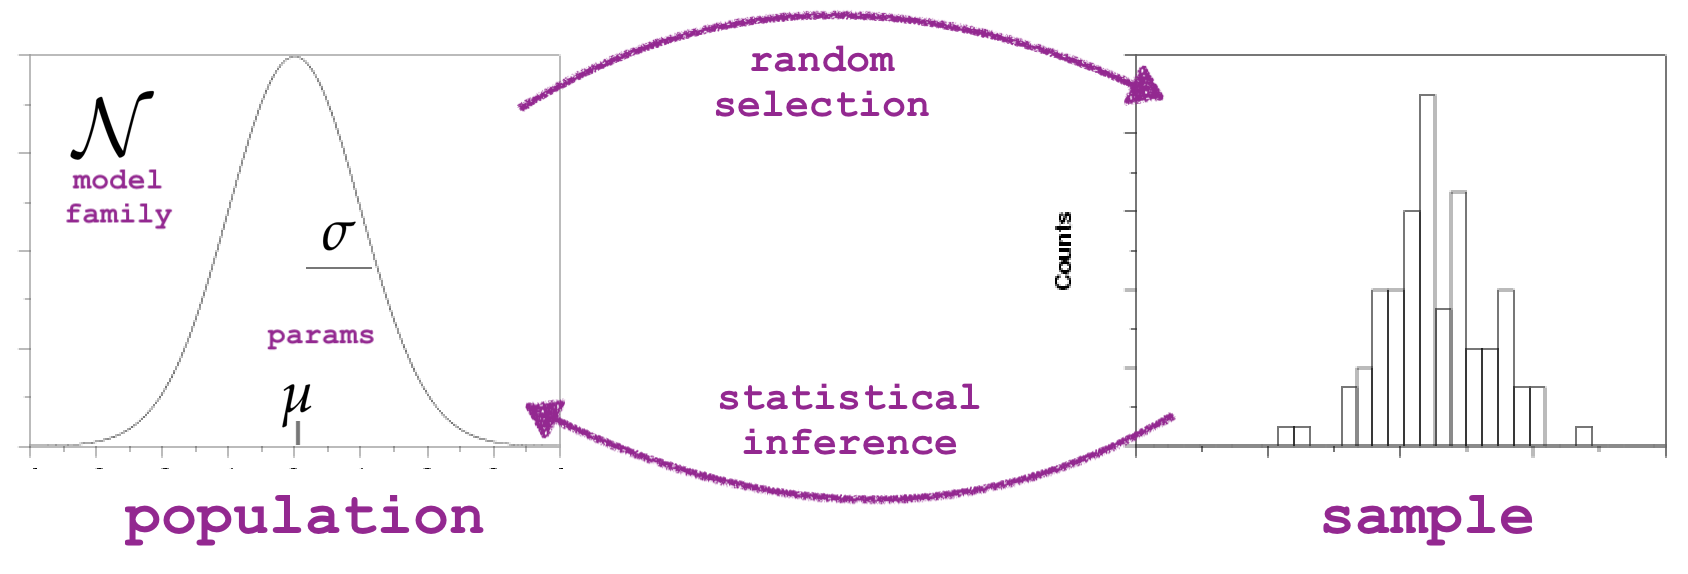
**Figure 1**. Illustration of the random selection mechanism which generates the data sample
and the statistical inference process, which tries to guess the population parameters.



## Example data analysis scenario

We'll use an example to ground the discussions in the rest of the notebook. 

### IQ scores data

Consider the following dataset,
which consists of IQ scores of 30 students who took a "smart drug" ☕.
The IQ scores are recorded in the following list.

In [3]:
iqs = [ 95.7, 100.1,  95.3, 100.7, 123.5, 119.4,  84.4, 109.6,
       108.7,  84.7, 111.0,  92.1, 138.4, 105.2,  97.5, 115.9,
       104.4, 105.6, 104.8, 110.8,  93.8, 106.6,  71.3, 130.6,
       125.7, 130.2, 101.2, 109.0, 103.8,  96.7]

In [4]:
# sample size (n)
len(iqs)

30

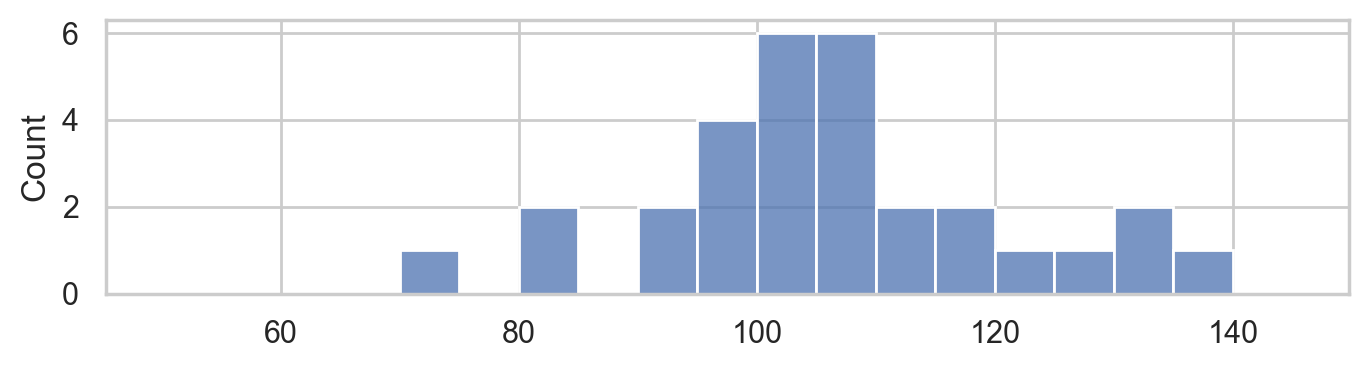

In [5]:
import seaborn as sns
sns.histplot(iqs, bins=range(50,150,5));

savefig(plt.gcf(), "figures/histplot_iqs.png")

### Descriptive statistics

In [6]:
from statistics import mean
mean(iqs)

105.89

In [7]:
from statistics import stdev as std
std(iqs)

14.658229417469641

### Statistical inference by eyeball

Move the sliders to choose the model parameters that best match the data.

In [8]:
import numpy as np
from scipy.stats import norm
from ipywidgets import interact

def plot_pop_and_sample(mu, sigma):
    # 1. Plot histogram of sample
    ax = sns.histplot(x=iqs, stat="density", bins=range(50,150,5), label="data")
    # 2. Plot probability density function of population model
    rvX = norm(mu, sigma)
    xs = np.linspace(50, 150, 1000)
    fXs = rvX.pdf(xs)
    sns.lineplot(x=xs, y=fXs, ax=ax, c="C0", label="model")
    print(f"current population model guess: X ~ N(mu={mu}, sigma={sigma})")

interact(plot_pop_and_sample, mu=(50,150,1), sigma=(3,40,1));

interactive(children=(IntSlider(value=100, description='mu', max=150, min=50), IntSlider(value=21, description…

### Research questions

The main research question we want to answer based on the IQ scores data is whether the smart drug had an effect on or not. We know the average IQ score is $\mu=100$ for the population in general (not the individuals from this experiment) with standard deviation $\sigma=15$ IQ points. If we compare the mean IQ score we observed in the sample of students who took the smart drug $\overline{\tt{iqs}}=105.89$  to people in the mean of the general population $\mu=100$, we see the students on the smart drug did better, which suggests the drug is effective.

On the other hand, the standard deviation of IQ scores is 15, which means that variations of +/- 15 around the mean of 100 are common, so perhaps observing a difference between observed mean and the theoretical mean of 5.89 is not uncommon.

This is precisely the situation why we need the tools of statistical inference. We'll use the hypothesis testing procedure to calculate how "surprising" it is to observe a difference of 5.89 from the expected population mean, and thus provide a principled answer to the question if the smart drug is effective.

Before we get to the hypothesis testing procedure, we'll need to introduce some prerequsite concepts: probability models and sampling distribributions.


## Probability model for the general population

Let's now build the specific probability model we need for the analysis of the students' IQ scores.
We know the IQ scores in the general population has mean $\mu=100$ and standard deviation $\sigma=15$.
We will denote the general population as $X \sim \mathcal{N}(\mu=100,\sigma=15)$.


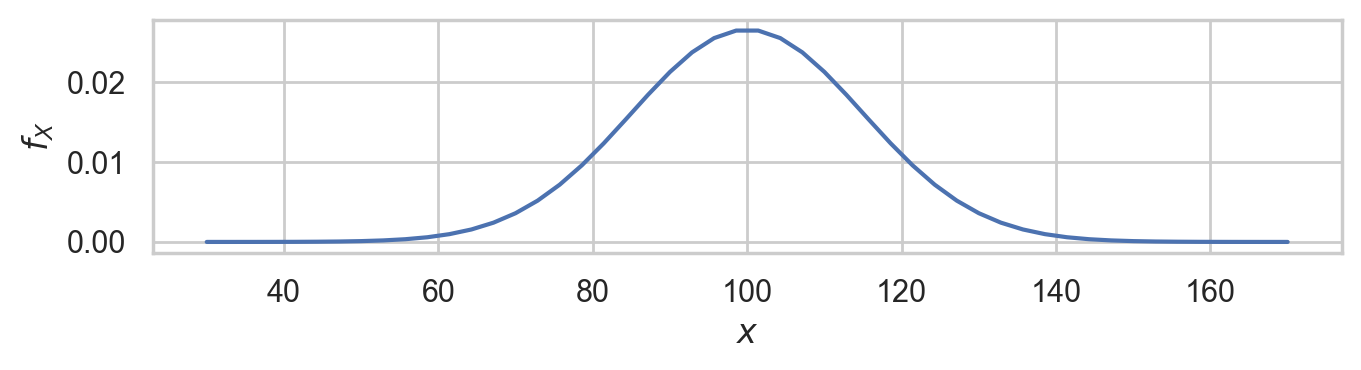

In [9]:
mu = 100
sigma = 15
rvX = norm(mu, sigma)

xs = np.linspace(30, 170)
ax = sns.lineplot(x=xs, y=rvX.pdf(xs));
ax.set_xlabel("$x$")
ax.set_ylabel("$f_{X}$")

savefig(plt.gcf(), "figures/samples_from_rvX_n30.png")

This is the distribution of IQ scores we can expect to observe for the general population.

### Random samples from the general population

We'll use the notation $\mathbf{X} = (X_1, X_2, \ldots, X_{30})$ to describe a *random sample* from the general population.

To get a idea of what these random samples look like,
we can generate $10$ samples $\mathbf{x}_1, \mathbf{x}_2, \mathbf{x}_3, \ldots, \mathbf{x}_{10}$ of size $n=30$ from $X \sim \mathcal{N}(\mu=100, \sigma=15)$ as follows.

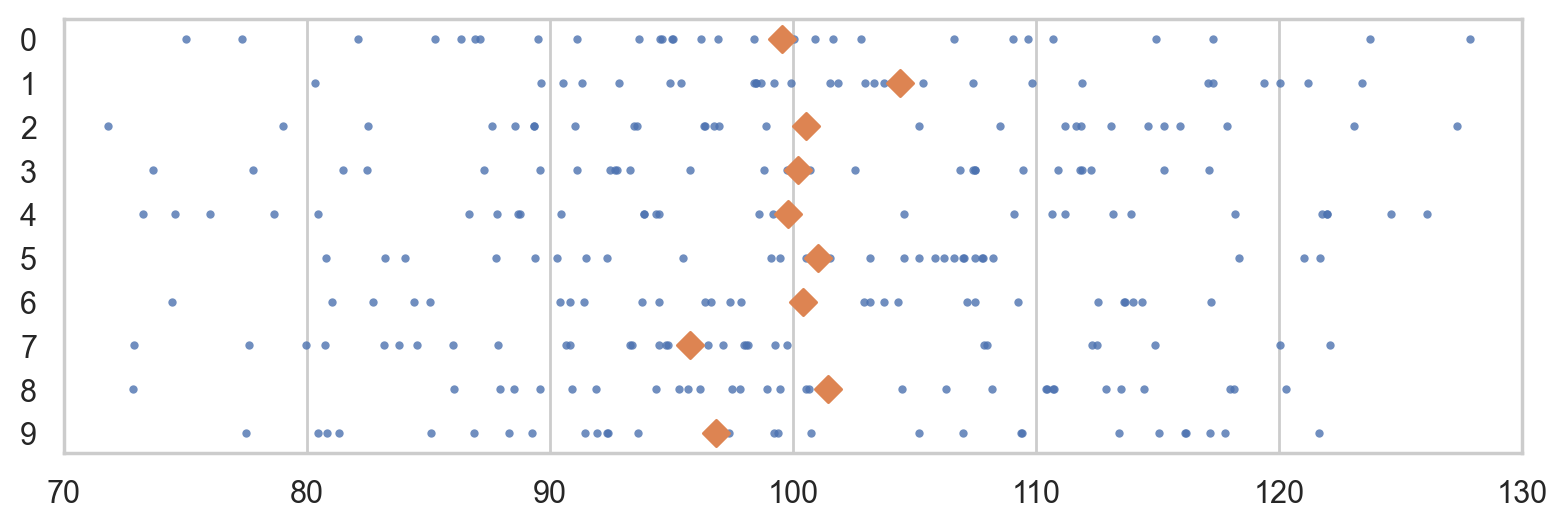

In [10]:
np.random.seed(5)

samples = [rvX.rvs(30) for i in range(10)]
with plt.rc_context({"figure.figsize":(8,2.8)}):
    ax = sns.stripplot(samples, orient="h", s=3, color="C0", alpha=0.8, jitter=0)
    ax.set_xlim([70,130])
    for i, sample in enumerate(samples):
        xbar = mean(sample)
        ax.scatter(xbar, i, marker="D", s=45, color="C1", zorder=10)

savefig(plt.gcf(), "figures/samples_from_rvX_n30.png")

The diamond markers indicate the position of the sample means computed from each sample:
$[\overline{\mathbf{x}}_1, \overline{\mathbf{x}}_2, \overline{\mathbf{x}}_3, \ldots, \overline{\mathbf{x}}_{10}]$.


In the next section we're going to talk about the distribution of the diamond shapes,
which correspond to the means computed from random samples.

## Sampling distributions

The *sampling distribution* of the mean for samples of size $n=30$ from the general population $X \sim \mathcal{N}(100,15)$ is the probability distribution of the random variable $\overline{\mathbf{X}} = \mathbf{Mean}(\mathbf{X})$,
where $\mathbf{X} = (X_1, X_2, \ldots, X_{30})$ is a *random sample* from $\mathcal{N}(100,15)$. The sampling distribution describes the kind of means we can expect to observe if
we compute the mean for a sample of size $n=30$ from the standard normal.


To visualize the sampling distribution of the mean $\overline{\mathbf{X}} = \texttt{mean}(\mathbf{X})$,
we can generate $N=1000$ samples from the population model:
$\mathbf{x}_1, \mathbf{x}_2, \mathbf{x}_3, \ldots, \mathbf{x}_{1000}$,
then plot a histogram of the means computed from the $1000$ random samples,
`xbars` = $[\overline{\mathbf{x}}_1, \overline{\mathbf{x}}_2, \overline{\mathbf{x}}_3, \ldots, \overline{\mathbf{x}}_{1000}]$,
where $\overline{\mathbf{x}}_j$ denotes the sample mean computed from the data in the $j$th sample,
$\overline{\mathbf{x}}_j = \texttt{mean}(\mathbf{x}_j)$.

In [11]:
N = 1000  # number of random samples
n = 30    # sample size

xbars = []
for j in range(0, N):
    sample = rvX.rvs(n)
    xbar = mean(sample)
    xbars.append(xbar)

# xbars[0:5]

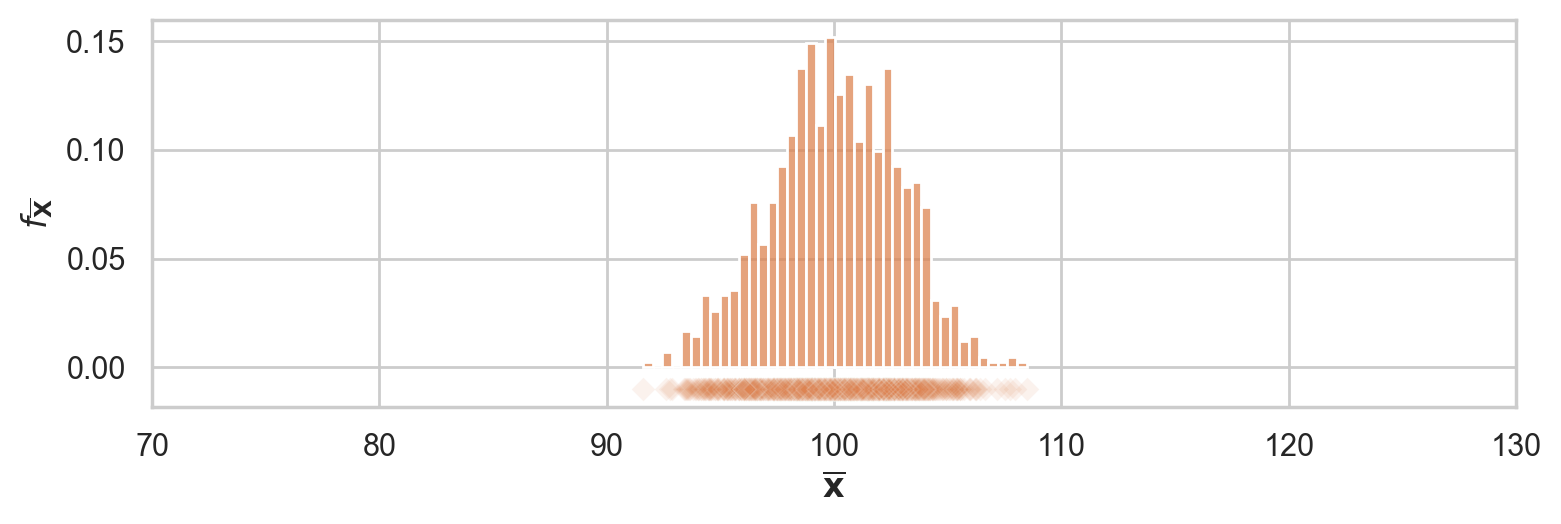

In [12]:
with plt.rc_context({"figure.figsize":(8,2.8)}):
    ax = sns.histplot(xbars, color="C1", bins=40, stat="density")
    ax.set_xlim([70,130])
    sns.scatterplot(x=xbars, y=-0.01, color="C1", marker="D", alpha=0.1, ax=ax)
    ax.set_xlabel("$\\overline{\\mathbf{x}}$")
    ax.set_ylabel("$f_{\\overline{\\mathbf{X}}}$");
    savefig(plt.gcf(), "figures/hist_sampling_dist_mean_rvX_n30_N1000.png")

The above figure shows the sampling distribution of the mean for samples of size $n=30$ from the general population model $X \sim \mathcal{N}(\mu=100, \sigma=15)$.
The histogram shows the "density of diamond shapes," and provides a representation of the sampling distribution of the mean $\overline{\mathbf{X}} = \tt{mean}(\mathbf{X})$.


### Two ways to work with sampling distributions

You can use either a math description (analytical formulas) or a computational description (simulations) for the sampling distribution. Although the two descriptions seem very different on the surface, they both describe the same underlying concept. I've compiled a little list of the key properties of the estimator $\tt{mean}$ to show the correspondences between two types of descriptions.


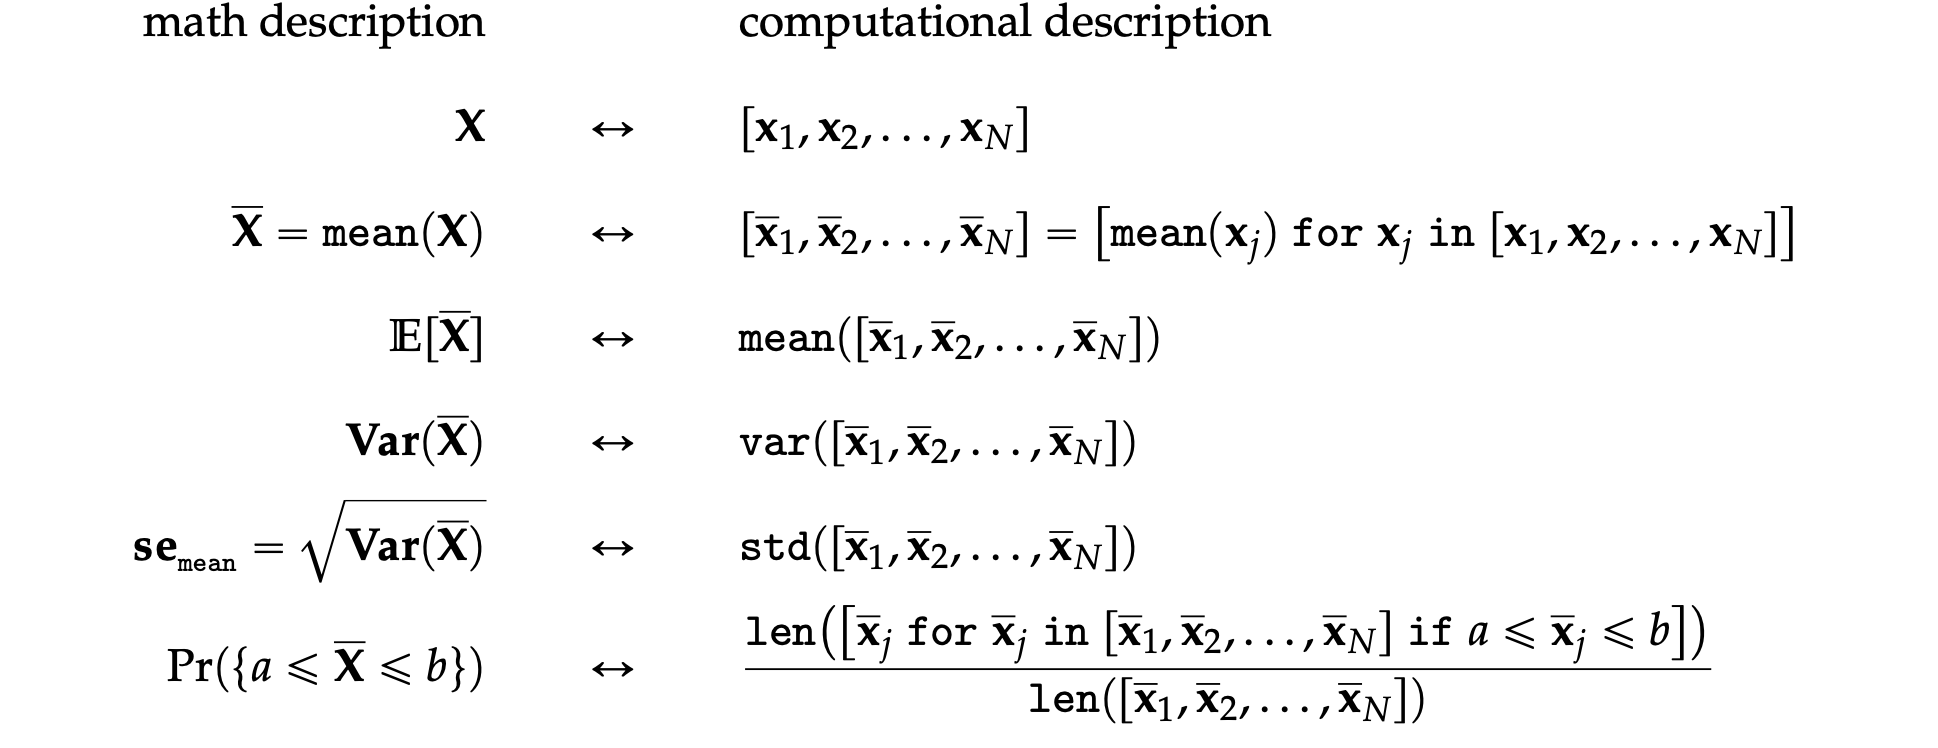


The two descriptions give us two different ways to do probability calculations. For example, we can visualize the sampling distribution of the estimator $\tt{mean}$, by plotting the probability density function of the random variable $\overline{\mathbf{X}} = \tt{mean}(\mathbf{X})$ or by plotting a histogram of the values $[\tt{mean}(\mathbf{x}_1), \tt{mean}(\mathbf{x}_2), \ldots, \tt{mean}(\mathbf{x}_N)]$.

Suppose someone asks us to compute the probability $\Pr(\{ a \leq \overline{\mathbf{X}} \leq b \})$, which describes the probability that the estimate computed from a random sample of size $n$ will be between $a$ and $b$. We can obtain the answer using the probability description by calculating the difference in the cumulative distribution function $\Pr(\{ a \leq \overline{\mathbf{X}} \leq b \}) = F_{\overline{\mathbf{X}}}(b) - F_{\overline{\mathbf{X}}}(a)$.  
Using the computational approach, we can obtain the same probability calculating by computing the \emph{proportion} of observations in the list $[\tt{mean}(\mathbf{x}_1), \tt{mean}(\mathbf{x}_2), \ldots, \tt{mean}(\mathbf{x}_N)]$ whose values are between $a$ and $b$. 


## Hypothesis testing using simulation

TODO: import from blog post and slides

In [13]:
np.random.seed(55)

n = 30     # sample size
N = 10000  # number of simulated samples

xbars = []
for j in range(0, N):
    sample = rvX.rvs(n)
    xbar = mean(sample)
    xbars.append(xbar)

We have seen this before,
but now generate using $N=10000$ to get higher presision.

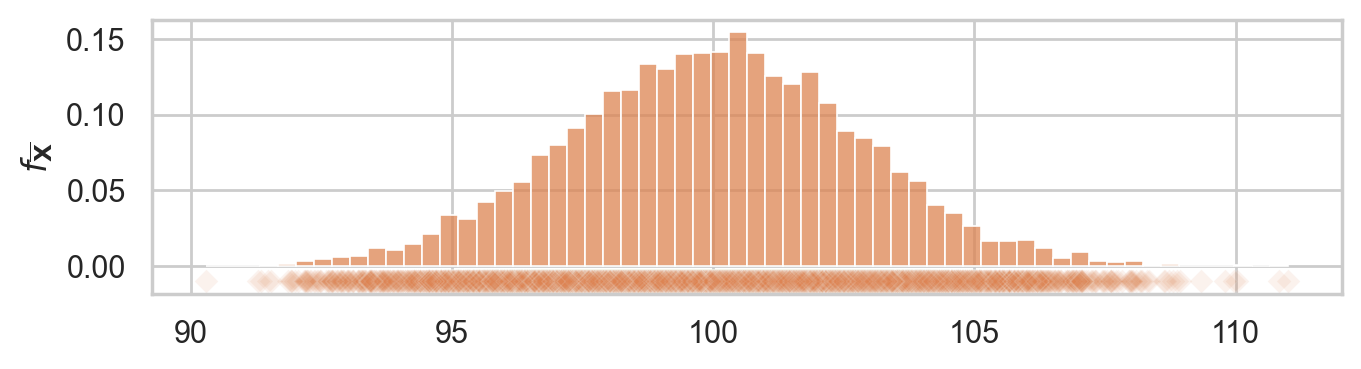

In [14]:
ax = sns.histplot(xbars, color="C1", stat="density")
sns.scatterplot(x=xbars, y=-0.01, color="C1", marker="D", alpha=0.1, ax=ax)
ax.set_ylabel("$f_{\\overline{\\mathbf{X}}}$")
savefig(plt.gcf(), "figures/hist_sampling_dist_mean_rvX_n30_N10000.png")

In [15]:
obsmean = mean(iqs)
obsmean

105.89

In [16]:
tail = [xbar for xbar in xbars if xbar > obsmean]
pvalue = len(tail) / len(xbars)
pvalue

0.0184

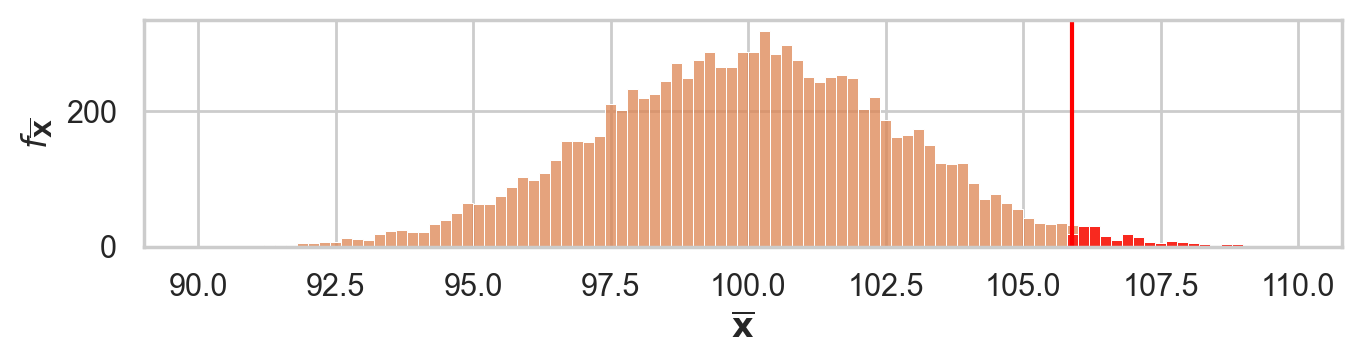

In [17]:
# plot the sampling distribution
bins = np.arange(90, 110, 0.2)
ax = sns.histplot(xbars, bins=bins, color="C1")

# plot red line for the observed statistic
plt.axvline(obsmean, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tail, ax=ax, bins=bins, color="red")
_ = ax.set_ylabel("$f_{\\overline{\\mathbf{X}}}$")
_ = ax.set_xlabel("$\\overline{\\mathbf{x}}$")

savefig(plt.gcf(), "figures/pvalue_viz_simulation_test_iqs.png")

#### Alternative $p$-value calculation using formula

In [18]:
from ministats import ttest_mean
ttest_mean(iqs, mu0=100, alt="greater")

0.01792942680682752

## Conclusion

## Links